In [1]:
import numpy as np
import torch
import scipy.signal as sp
import torch.nn.functional as F
import matplotlib.pyplot as plt
#import torchaudio

In [2]:
def gauss(L, sigma):
    g = np.exp(-np.pi * np.arange(-L//2,L//2)**2 / (sigma/2)**2)
    g_c = np.roll(g, L//2)
    return g_c.reshape(1,-1)

def smooth_box(L, supp):
    puff = 150
    g = (np.cos(np.linspace(0,np.pi,150))/2+0.5).reshape(1,-1)
    o = np.concatenate([np.ones((1,supp//2-puff)), g, np.zeros((1,L-supp)),np.fliplr(g),np.ones((1,supp//2-puff))],axis=1)
    return o.T

In [3]:
with open('audfreqz.npy', 'rb') as f:
    gf = np.load(f)

with open('audfc.npy', 'rb') as f:
    fc = np.load(f)

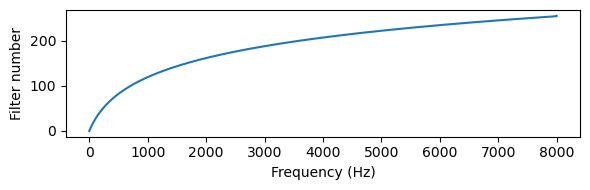

In [4]:
plt.figure(figsize=(6,2))
plt.plot(fc,np.arange(257))
plt.ylabel('Filter number')
plt.xlabel('Frequency (Hz)')

plt.tight_layout()
plt.savefig('fc.pdf', bbox_inches='tight')
plt.show()

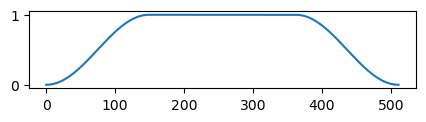

In [5]:
supp = 512
w = smooth_box(16000, supp)

plt.figure(figsize=(5,1))

plt.plot(np.roll(w,256)[:512,0])
plt.show()

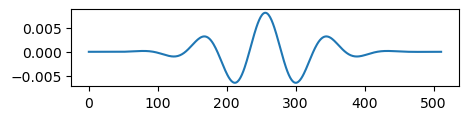

In [6]:
# Audlet style filterbank
w_alt = gauss(16000, 400).reshape(-1,1)

gi = np.fft.ifft(gf, axis=0)
gi_re_supp = np.real(gi[:,:-1]) * w_alt
W_c = np.concatenate((gi_re_supp[:supp//2], gi_re_supp[-supp//2:]), axis=0).T
W_aud = np.roll(W_c, supp//2, axis=1)#+np.roll(W_c, -supp//2, axis=1)+np.roll(W_c, -supp//2, axis=0)

plt.figure(figsize=(5,1))
plt.plot(W_aud[40,:])
plt.show()

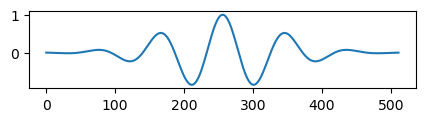

In [7]:
# Gabor style filterbank

#w_alt = np.roll(smooth_box(512, supp),256)
#w_alt = np.cos(np.linspace(-np.pi,np.pi,512))/2+0.5
w_alt2 = np.roll(gauss(512, 400),256).reshape(-1)


# cosine of length 512 with 500Hz
W_gab = np.zeros((256,512))
for i in range(256):
    W_gab[i,:] = np.cos(2*np.pi*fc[i]*np.arange(-256,256)/16000)*w_alt2

plt.figure(figsize=(5,1))
plt.plot(W_gab[40,:])
plt.show()

In [9]:
from fb_utils import fir_tightener3000, fir_tightener4000, frame_bounds_lp, random_filterbank

In [9]:
# W_long = np.ppend(np.roll(W,supp//2), np.zeros((W.shape[0], 10000-512)), axis=1)
# W_long_tight = fir_tightener3000(W_long, 512)
# W_tight = np.roll(W_long_tight[:,:supp], supp//2, axis=1)a

In [10]:
W = W_aud

In [11]:
W_tight = fir_tightener3000(W, 512)
W_tight_f = np.abs(np.fft.fft(W_tight, axis=1))**2
# normalize
W_tight_f = W_tight_f / np.max(W_tight_f, axis=1).reshape(-1,1)

In [49]:
W_random = random_filterbank(512, 256, 512, norm=True, tight=False, to_torch=False, support_only=True)
W_random = fir_tightener3000(W_random, 512)
W_random_f = np.abs(np.fft.fft(W_random, axis=1))**2
# normalize
W_random_f = W_random_f / np.max(W_random_f, axis=1).reshape(-1,1)

In [13]:
W_bias = np.real(np.fft.ifft(np.fft.fft(W_tight, axis=1) * np.fft.fft(W_random, axis=1), axis=1))
W_bias_tight = fir_tightener3000(W_bias, 512)
W_bias_tight_f = np.abs(np.fft.fft(W_tight, axis=1) * np.fft.fft(W_random, axis=1))**2
# normalize
W_bias_tight_f = W_bias_tight_f / np.max(W_bias_tight_f, axis=1).reshape(-1,1)

In [14]:
A, B = frame_bounds_lp(W)
A_t, B_t = frame_bounds_lp(W_tight)
A_r, B_r = frame_bounds_lp(W_random)
A_b, B_b = frame_bounds_lp(W_bias_tight)

In [15]:
# print all condition numbers B/A
print(B/A, B_t/A_t, B_r/A_r, B_b/A_b)

4.747706255530254 1.0000000000000024 1.000000000000004 1.0000000000000024


In [17]:
# for i in range(W_random.shape[0]):
#     W_random[i,:] = fir_tightener3000(W_random[i,:].reshape(1,-1), 512)
W_random = fir_tightener4000(W, 512)

In [58]:
A, B = frame_bounds_lp(W_random)
print(A,B,B/A)

0.9999999999999987 1.0000000000000016 1.0000000000000029


In [19]:
import librosa
speech_full = librosa.load('speech.wav')
speech_full = librosa.resample(speech_full[0],orig_sr=22050,target_sr=16000)
len = 10000
speech = speech_full[1500:1500+len].reshape(1,-1)
speech = speech / np.linalg.norm(speech)

In [20]:
#random torch of length 10000
x = torch.randn((1,10000))
x_norm = x / torch.norm(x)
x_norm = torch.tensor(speech)

W_random_tensor = torch.tensor(W_random, dtype=torch.float32)
W_bias_tight_tensor = torch.tensor(W_bias_tight, dtype=torch.float32)
W_bias_tensor = torch.tensor(W_bias, dtype=torch.float32)
W_tight_tensor = torch.tensor(W_tight, dtype=torch.float32)

In [78]:
# conv1D - auditory filterbank
x_enc = F.conv1d(x_norm.unsqueeze(0), W_random_tensor.unsqueeze(1), stride=1)
x_enc_2 = torch.real(torch.fft.ifft(torch.fft.fft(x_enc, dim=1) * torch.fft.fft(W_tight_tensor, n=9489, dim=1), dim=1, norm='backward'))

# mixed filterbank
W_both = torch.real(torch.fft.ifft(torch.fft.fft(W_random_tensor, dim=1) * torch.fft.fft(W_tight_tensor, dim=1), dim=1, norm='backward'))

x_enc_both = F.conv1d(x_norm.unsqueeze(0), W_both.unsqueeze(1), stride=1, padding=0)
x_tilde_both = F.conv_transpose1d(x_enc_both, W_both.unsqueeze(1), stride=1, padding=0)

x_tilde_2 = F.conv_transpose1d(x_enc_2, W_both.unsqueeze(1), stride=1, padding=0).squeeze(0)

In [79]:
x_norm.shape, x_tilde_2.shape

(torch.Size([1, 10000]), torch.Size([1, 10000]))

In [80]:
torch.norm(x_enc), torch.norm(x_enc_both), torch.norm(x_tilde_2), torch.norm(x_norm[:,2000:8000] - x_tilde_2[:,2000:8000])

(tensor(16.2455), tensor(1.0158), tensor(0.1561), tensor(0.8709))

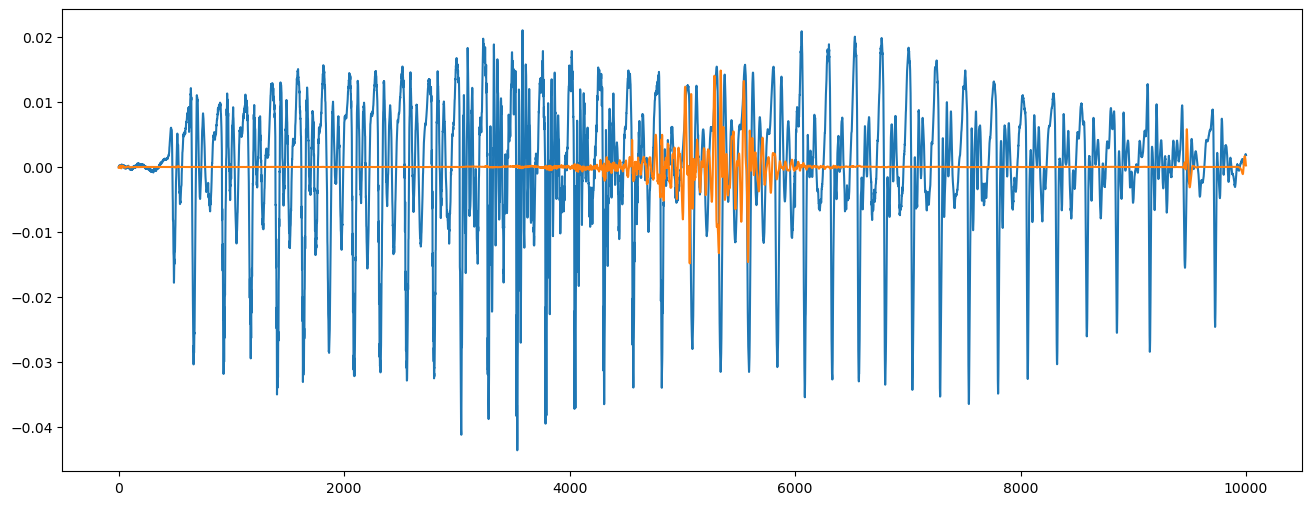

In [81]:
plt.figure(figsize=(16, 6))

plt.plot(x_norm.squeeze().numpy())
plt.plot(x_tilde_2[0,:10000].squeeze().numpy())

In [62]:
A, B = frame_bounds_lp(W_both)
print(A,B,B/A)

0.9999996843101414 1.000000133001974 1.0000004486919742


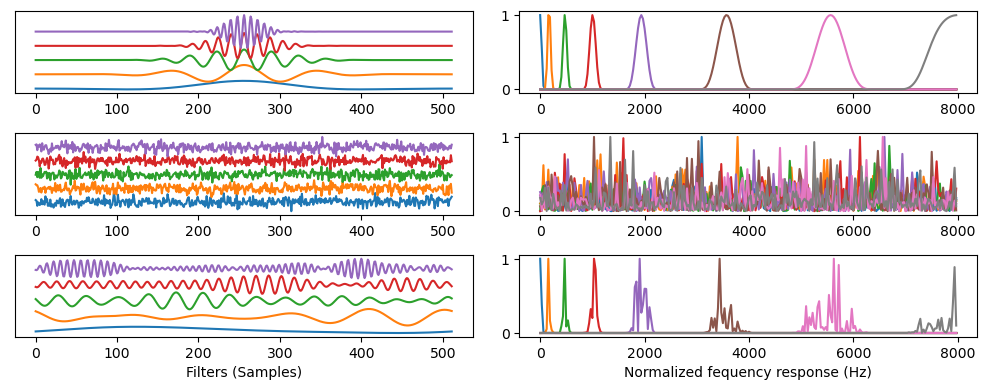

In [51]:
# 4 subplots
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_size_inches(10, 4)

x = np.arange(0, supp, 1)

ax1.plot(x,W_tight[10,:]/np.linalg.norm(W_tight[10,:])-0.4)
ax1.plot(x,W_tight[40,:]/np.linalg.norm(W_tight[40,:])-0.2)
ax1.plot(x,W_tight[80,:]/np.linalg.norm(W_tight[80,:]))
ax1.plot(x,W_tight[120,:]/np.linalg.norm(W_tight[120,:])+0.2)
ax1.plot(x,W_tight[160,:]/np.linalg.norm(W_tight[160,:])+0.4)
# remove yticks
ax1.set_yticks([])

ax2.plot(W_tight_f[[0,40,80,120,160,200,230,255],:supp//2].T)
ax2.set_xticks([0, 64, 128, 192, 256])
ax2.set_xticklabels(['0', '2000' , '4000', '6000', '8000'])

ax3.plot(x,W_random[0,:]/np.linalg.norm(W_random[10,:])-0.4)
ax3.plot(x,W_random[40,:]/np.linalg.norm(W_random[40,:])-0.2)
ax3.plot(x,W_random[80,:]/np.linalg.norm(W_random[80,:]))
ax3.plot(x,W_random[120,:]/np.linalg.norm(W_random[120,:])+0.2)
ax3.plot(x,W_random[160,:]/np.linalg.norm(W_random[160,:])+0.4)
# remove yticks
ax3.set_yticks([])

ax4.plot(W_random_f[[0,40,80,120,160,200,230,255],:supp//2].T)
ax4.set_xticks([0, 64, 128, 192, 256])
ax4.set_xticklabels(['0', '2000' , '4000', '6000', '8000'])

ax5.plot(x,W_bias_tight[0,:]/np.linalg.norm(W_bias_tight[10,:])-0.4)
ax5.plot(x,W_bias_tight[40,:]/np.linalg.norm(W_bias_tight[40,:])-0.2)
ax5.plot(x,W_bias_tight[80,:]/np.linalg.norm(W_bias_tight[80,:]))
ax5.plot(x,W_bias_tight[120,:]/np.linalg.norm(W_bias_tight[120,:])+0.2)
ax5.plot(x,W_bias_tight[160,:]/np.linalg.norm(W_bias_tight[160,:])+0.4)
# remove yticks
ax5.set_yticks([])

ax5.set_xlabel('Filters (Samples)')

ax6.plot(W_bias_tight_f[[0,40,80,120,160,200,230,255],:supp//2].T)

ax6.set_xticks([0, 64, 128, 192, 256])
ax6.set_xticklabels(['0', '2000' , '4000', '6000', '8000'])
ax6.set_xlabel('Normalized fequency response (Hz)')

plt.tight_layout()
plt.savefig('filters.pdf', bbox_inches='tight')
plt.show()

In [152]:
import librosa
speech_full = librosa.load('speech.wav')
speech_full = librosa.resample(speech_full[0],orig_sr=22050,target_sr=16000)
len = 10000
speech = speech_full[1500:1500+len].reshape(1,-1)
speech = speech / np.linalg.norm(speech)
#speech = speech / np.max(np.abs(speech))

In [22]:
f = torch.tensor(speech, dtype=torch.float32)
# pad by supp//2 to emulate circular convolution
#f_cat = F.pad(f, pad=(supp//2,supp//2-1), mode='circular')
f_cat = f
# make all to torch
W_tensor = torch.tensor(W, dtype=torch.float32)
W_tight_tensor = torch.tensor(W_tight, dtype=torch.float32)
W_random_tensor = torch.tensor(W_random, dtype=torch.float32)
W_bias_tight_tensor = torch.tensor(W_bias_tight, dtype=torch.float32)

# do the forward pass with conv1d
stride = 64

enc = F.conv1d(f_cat.unsqueeze(0), W_tensor.unsqueeze(1), stride=stride, padding=0)
enc_tight = F.conv1d(f_cat.unsqueeze(0), W_tight_tensor.unsqueeze(1), stride=stride,padding=0)
enc_random = F.conv1d(f_cat.unsqueeze(0), W_random_tensor.unsqueeze(1), stride=stride, padding=0)
enc_bias = F.conv1d(f_cat.unsqueeze(0), W_bias_tight_tensor.unsqueeze(1), stride=stride,padding=0)

# pad by supp//2 to emulate circular convolution
# enc = F.pad(enc, pad=(supp//2,supp//2-1), mode='circular')
# enc_tight = F.pad(enc_tight, pad=(supp//2,supp//2-1), mode='circular')
# enc_random = F.pad(enc_random, pad=(supp//2,supp//2-1), mode='circular')
# enc_bias = F.pad(enc_bias, pad=(supp//2,supp//2-1), mode='circular')

# now forward to the transpose of the filterbank
out = F.conv_transpose1d(enc, W_tensor.unsqueeze(1), stride=stride, padding=0)
out_tight = F.conv_transpose1d(enc_tight, W_tight_tensor.unsqueeze(1), stride=stride, padding=0)
out_random = F.conv_transpose1d(enc_random, W_random_tensor.unsqueeze(1), stride=stride, padding=0)
out_bias = F.conv_transpose1d(enc_bias, W_bias_tight_tensor.unsqueeze(1), stride=stride, padding=0)

In [23]:
f_cat.shape,f.shape,enc_tight.shape, W_random_tensor.shape, out_tight.shape

(torch.Size([1, 10000]),
 torch.Size([1, 10000]),
 torch.Size([1, 256, 149]),
 torch.Size([256, 512]),
 torch.Size([1, 1, 9984]))

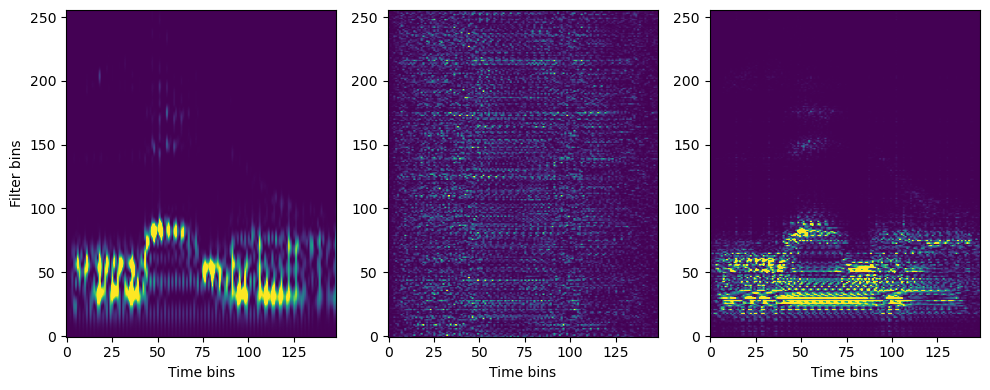

In [24]:
# imshow the enc
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(np.abs(enc_tight[0,:,:].detach().numpy())**2, vmin=0, vmax=0.000005, aspect='auto')
# flip y ticks  to have 0 at the bottom
plt.gca().invert_yaxis()
plt.xlabel('Time bins')
plt.ylabel('Filter bins')
#plt.title('Auditory FIR filters')

plt.subplot(1, 3, 2)
plt.imshow(np.abs(enc_random[0,:,:].detach().numpy())**2, vmin=0, vmax=0.000005, aspect='auto')
plt.gca().invert_yaxis()
plt.xlabel('Time bins')
#plt.title('Random FIR filters')

plt.subplot(1, 3, 3)
plt.imshow(np.abs(enc_bias[0,:,:].detach().numpy())**2, vmin=0, vmax=0.000005, aspect='auto')
plt.gca().invert_yaxis()
plt.xlabel('Time bins')
#plt.title('Inductively biased FIR filters')

plt.tight_layout()
plt.savefig('responses.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()



In [25]:
enc_tight.squeeze(0).shape,out_tight.squeeze(0).shape

(torch.Size([256, 149]), torch.Size([1, 9984]))

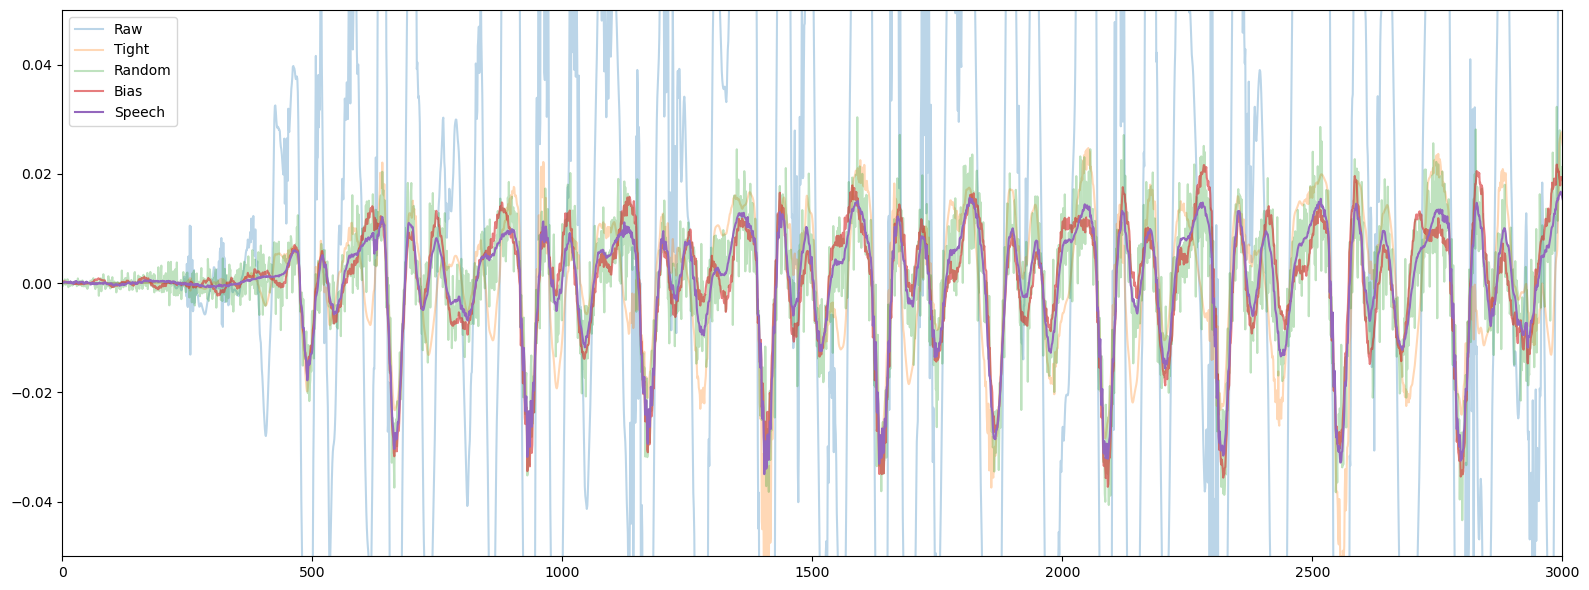

6.5806866
0.8066546
0.50735116
0.3400327


In [26]:
leni = out_tight.squeeze(0).shape[-1]
rolled = np.roll(out.squeeze(0)[0,:leni].detach().numpy().reshape(1,-1),0) * stride
tight_rolled = np.roll(out_tight.squeeze(0)[0,:leni].detach().numpy().reshape(1,-1),0) * stride
random_rolled = np.roll(out_random.squeeze(0)[0,:leni].detach().numpy().reshape(1,-1),0) * stride
bias_rolled = np.roll(out_bias.squeeze(0)[0,:leni].detach().numpy().reshape(1,-1),0) * stride

plt.figure(figsize=(16, 6))

plt.plot(rolled[0,:],alpha=0.3)
plt.plot(tight_rolled[0,:],alpha=0.3)
plt.plot(random_rolled[0,:],alpha=0.3)
plt.plot(bias_rolled[0,:],alpha=0.6)
plt.plot(speech[0,:])
plt.xlim(0,3000)
plt.ylim(-0.05,0.05)
plt.legend(['Raw','Tight','Random','Bias','Speech'])
plt.tight_layout()
plt.show()

print(np.linalg.norm(rolled-speech[0,:leni])/np.linalg.norm(speech[0,:leni]))
print(np.linalg.norm(tight_rolled-speech[0,:leni])/np.linalg.norm(speech[0,:leni]))
print(np.linalg.norm(random_rolled-speech[0,:leni])/np.linalg.norm(speech[0,:leni]))
print(np.linalg.norm(bias_rolled-speech[0,:leni])/np.linalg.norm(speech[0,:leni]))

In [27]:
from IPython.display import Audio
Audio(data=out_tight.squeeze(0)[:,:], rate=16000)

In [28]:
from IPython.display import Audio
Audio(data=speech, rate=16000)

In [ ]:
def auditory_bias(W_random):
    W_bias = torch.real(torch.fft.ifft(torch.fft.fft(W_tight, dim=-1) * torch.fft.fft(W_random, dim=-1), dim=-1))
    W_bias_tight = fir_tightener3000(W_bias, 512)
    return W_bias_tight

In [34]:
with open('audfreqz.npy', 'rb') as f:
    gf = np.load(f)

def gauss(L, sigma):
    g = np.exp(-np.pi * np.arange(-L//2,L//2)**2 / (sigma/2)**2)
    g_c = np.roll(g, L//2)
    return g_c.reshape(1,-1)

w_alt = gauss(16000, 400).reshape(-1,1)
gi = np.fft.ifft(gf, axis=0)
gi_re_supp = np.real(gi[:,:]) * w_alt
W_c = np.concatenate((gi_re_supp[:supp//2], gi_re_supp[-supp//2:]), axis=0).T
W_aud = np.roll(W_c, supp//2, axis=1)
W_aud_tight = fir_tightener3000(W_aud, 512)

with open('auditory_filters.npy', 'wb') as f:
    np.save(f, W_aud_tight)

In [32]:
W_aud_tight.shape

(257, 512)

In [33]:
frame_bounds_lp(W_aud_tight)

(0.999999999999999, 1.0000000000000013)